In [234]:
%matplotlib inline

In [235]:
import numpy as np
import pandas as pd

In [236]:
import cv2

In [237]:
import matplotlib.pyplot as plt

In [238]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from utils.postprocessing import morph_masks
from utils.plotting import plot_mask
from predict import get_prediction_filename

# Load dataset

In [239]:
nb_folds = 5
fold_number = 0
model_name = 'unet_ds'
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = True

In [240]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [241]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

In [242]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [243]:
images = np.stack(images)
masks = np.stack(masks)

In [244]:
images.shape, masks.shape

((34, 500, 500, 3), (34, 500, 500))

## Load predictions

In [245]:
filename = get_prediction_filename(model_name, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
_, predictions = load_pickle(filename)

In [256]:
threshold = 0.4

In [257]:
predictions_mask = np.zeros_like(predictions)
predictions_mask[predictions>threshold] = 1

In [258]:
predictions.shape, predictions_mask.shape

((34, 500, 500), (34, 500, 500))

## Get score

In [259]:
score = topcoder_metric(masks, predictions_mask)

In [260]:
print('Score:', score)

Score: 854334.944208


# Post-processing

In [261]:
scores = []
for kernel_size in range(1,20, 2):
    predictions_mask_opened = morph_masks(predictions_mask, kernel_size, operation='open')
    predictions_mask_closed = morph_masks(predictions_mask, kernel_size, operation='close')    
    predictions_mask_opened_closed = morph_masks(
        morph_masks(predictions_mask, kernel_size, operation='open'),
        kernel_size, operation='close'
    )

    
    score_opened = topcoder_metric(masks, predictions_mask_opened)
    score_closed = topcoder_metric(masks, predictions_mask_closed)
    score_opened_closed = topcoder_metric(masks, predictions_mask_opened_closed)    
    
    scores.append({'score_open': score_opened, 'score_close': score_closed, 'score_open_close': score_opened_closed, 'kernel_size': kernel_size})

scores = pd.DataFrame(scores)

In [262]:
scores

,kernel_size,score_close,score_open,score_open_close
0,1,854334.944208,854334.944208,854334.944208
1,3,854430.374730,854276.770368,854338.608550
2,5,854541.921803,854251.229240,854435.333892
3,7,854658.949400,854205.699318,854431.339029
4,9,854755.720892,854088.265880,854246.947416
5,11,854717.686734,853717.776787,853746.978183
6,13,854392.509402,852980.626123,852780.596532
7,15,853844.398286,851817.989758,851282.115166
8,17,853490.104281,850780.929105,850024.863998
9,19,852948.744994,847934.597959,846730.110316


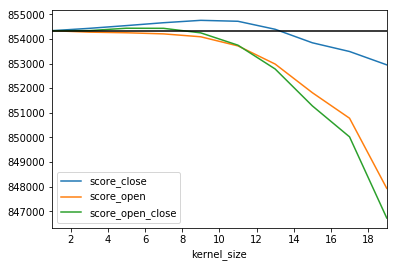

In [263]:
ax = scores.plot(x='kernel_size', y=['score_close', 'score_open', 'score_open_close'])
ax.axhline(y=score, c='black')

In [172]:
# 0 - 13
# 1 - 6
# 2 - 13
# 3 - 9
# 4 - 17

In [173]:
(13 + 6 + 13 + 9 + 17) / 5

11.6

# Plot some masks

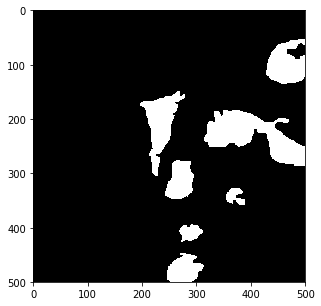

In [254]:
plot_mask(masks[1])

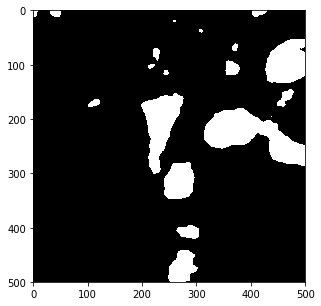

In [255]:
plot_mask(predictions_mask[1])

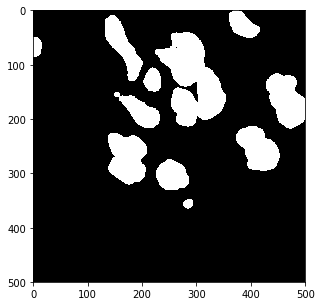

In [176]:
plot_mask(morph_masks(predictions_mask[1], kernel_size=11))

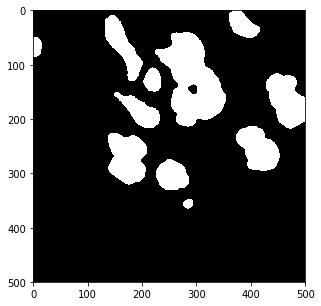

In [177]:
plot_mask(morph_masks(morph_masks(predictions_mask[1], kernel_size=11), kernel_size=11, operation='close'))